# Breast Cancer Prediction
**Dataset**: <https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/code?datasetId=180&sortBy=voteCount>

**Process:**
- Data Exploration
- Model Selection with NestCV: Decision Tree, KNN, Logistic Regression, Support Vector Machine
- Create final model to predict test data

In [77]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
import matplotlib.pyplot as pltsk
import scikitplot as skplt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn.metrics import average_precision_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler


# from sklearn.feature_selection import RFECV, SelectFromModel
# from sklearn.decomposition import PCA
# from matplotlib.colors import ListedColormap
# from sklearn import svm, datasets
# from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_curve,auc
# import scikitplot as skplt
# from sklearn import metrics
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import matthews_corrcoef


## Overview

After performing the nested cross validation among the four models, the mean accuracy of cross validation of each model is: Decision Tree (0.934),KNN (0.964), Logistic Regression (0.963) and SVM (0.977). **The best model is SVM with the best parameter C = 100, gamma = 0.0001, kernal = 'rbf'.** I then created a model with SVM and made the prediction on test data, and **the model accuracy on test data is 0.9035 along with recall positive 0.88 and precision positive 0.74.**

In addition, I present the  drew the ROC curve and lift curve as below. The ROC curve is pretty close to the top-left corner, showing the performance is not bad. 

## Explore Data

In [11]:
# Import dataset
name = ['ID','MB','mean radius' ,'mean texture', 
         'mean perimeter' ,'mean area',
         'mean smoothness', 'mean compactness' ,
         'mean concavity',
         'mean concave points' ,'mean symmetry', 
         'mean fractal dimension',
         'radius error', 'texture error', 'perimeter error', 
         'area error',
         'smoothness error', 'compactness error', 'concavity error',
         'concave points error', 'symmetry error', 
         'fractal dimension error',
         'worst radius', 'worst texture', 'worst perimeter',
         'worst area', 'worst smoothness', 'worst compactness',
         'worst concavity', 'worst concave points', 
         'worst symmetry', 'worst fractal dimension']

df = pd.read_csv('breast_cancer.data', header = None, names = name)

df.head(3)

,ID,MB,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [12]:
# I'll firstly take a look at the dataset shape, check all the column types 
n_row, n_features = df.shape
print(f'The dataset has {n_row} rows and {n_features} columns')


The dataset has 569 rows and 32 columns


In [13]:
# Check the data type of each column
print(df.isnull().sum().tolist())
df.info()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   MB                       569 non-null    object 
 2   mean radius              569 non-null    float64
 3   mean texture             569 non-null    float64
 4   mean perimeter           569 non-null    float64
 5   mean area                569 non-null    float64
 6   mean smoothness          569 non-null    float64
 7   mean compactness         569 non-null    float64
 8   mean concavity           569 non-null    float64
 9   mean concave points      569 non-null    float64
 10  mean symmetry            569 non-null    float64
 11  mean fractal dimension   569 non-null    float64
 12  radius error             569 non-null

In [15]:
# transform target variable into binary data
df['MB'] = [1 if i == 'M' else 0 for i in df['MB']]

# Take a look at the dataset statistics and check the number of data in each class of target variable
df.describe() 

,ID,MB,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


The mean of MB column is 0.37 means there're 37% malignant observation in this dataset

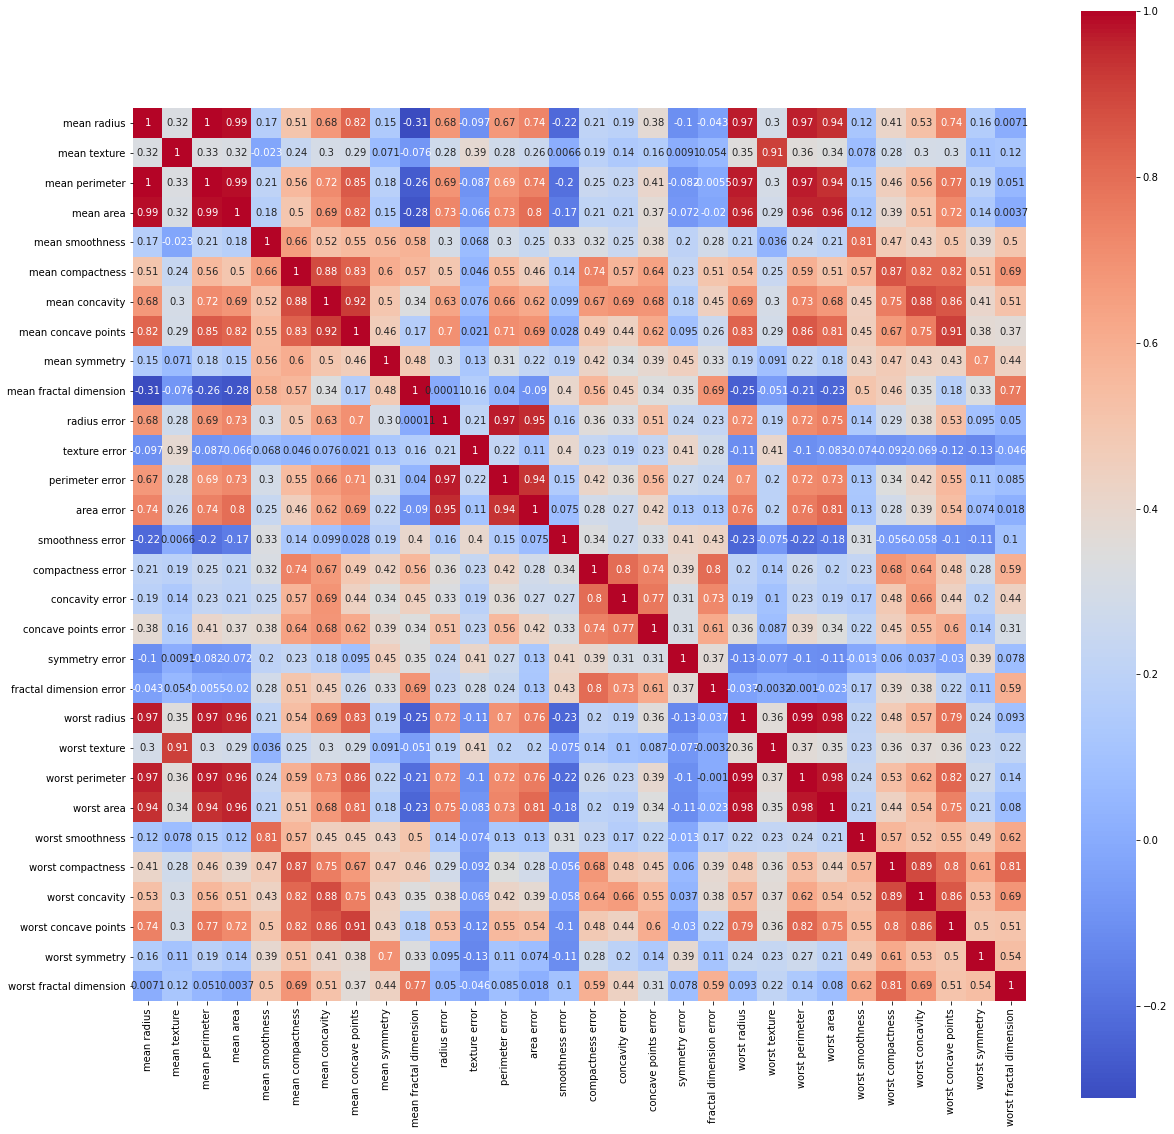

In [24]:
# Present feature correlation with heatmap
df_corr = df.iloc[:, 2:].corr()
plt.subplots(figsize=(20, 20))
sns.heatmap(df_corr, cmap = 'coolwarm', annot = True, square = True)
plt.show()


Since there are too many features, I decided to choose 3 features with the highest correlation

In [26]:
corr_matrix = df.iloc[:, 1:].corr()
top_3 = abs(corr_matrix['MB']).sort_values(ascending=False)[1:4]
print(top_3)

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
Name: MB, dtype: float64


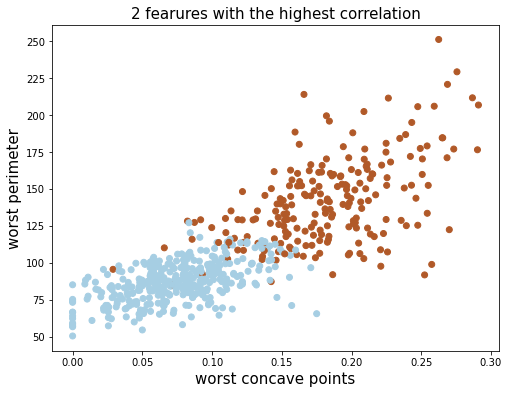

In [46]:
# Let's first visualize the top two features with the highest correlation
X = df.loc[:, ['worst concave points', 'worst perimeter']].values 
Y = df['MB']

x_min, x_max = X[:, 0].min() - .02, X[:, 0].max() + .02
y_min, y_max = X[:, 1].min() - .02, X[:, 1].max() + .02

# Plot the training points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('worst concave points', fontsize = 15)
plt.ylabel('worst perimeter', fontsize = 15)
plt.title('Two fearures with the highest correlation', fontsize = 15)
plt.show()

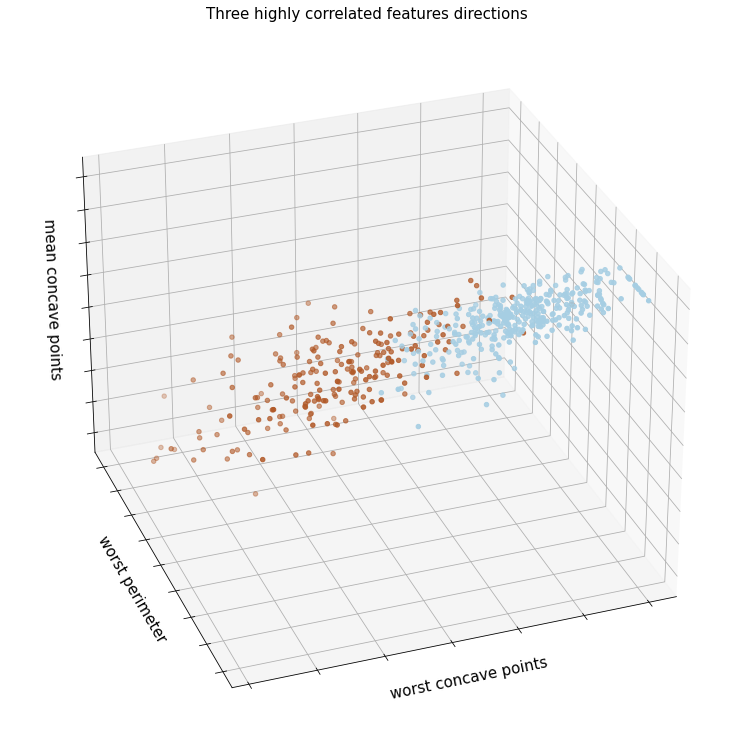

In [53]:
# Then we take a look on the top three features with the highest correlation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 12))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = df.loc[:, ['worst concave points', 
                       'worst perimeter',
                       'mean concave points']].values
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], 
           X_reduced[:, 2], c=Y, cmap=plt.cm.Paired)
ax.set_title("Three highly correlated features directions", fontsize = 15)
ax.set_xlabel("worst concave points", fontsize = 15)
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("worst perimeter", fontsize = 15)
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("mean concave points", fontsize = 15)
ax.w_zaxis.set_ticklabels([])
plt.show()

# Model Selection with Nested Cross Validation
I perform nested cross validation to find the best model among 5 chosen models for this dataset

In [70]:
# create a dict to record the performance of all models
f_measure_score = {'decision_tree':{},'knn':{},'logistic':{},'svm':{}}

In [61]:
# Define cross-validation for inner and outer loops,
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'accuracy'

In [62]:
# Create param_grid for all the hyperparameters

# Decition Tree hyperparamter
depth = list(range(1,25))
weight_options = ["entropy", "gini"]
dt_paramGrid = dict(max_depth = depth, criterion = weight_options)

# Logistic Regression hyperparamter
c_values = [10**i for i in list(range(-5, 6))]
multiclass = ['multinomial','ovr']
lr_paramGrid = dict(C = c_values, multi_class = multiclass)

# KNN hyperparamter
k = list(range(1,31))
knn_paramGrid = dict(n_neighbors = k)

# SVM hyperparamter
svm_paramGrid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]


In [66]:
# Define all the models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

dt = DecisionTreeClassifier()
lr = LogisticRegression(solver ='newton-cg')
knn = KNeighborsClassifier()
svm = SVC(random_state = 42,probability = True)


In [68]:
# Inner loop
dt_clf = GridSearchCV(estimator=dt, param_grid=dt_paramGrid, cv=inner_cv)
lr_clf = GridSearchCV(lr, param_grid=lr_paramGrid, cv=inner_cv)
knn_clf = GridSearchCV(knn, param_grid=knn_paramGrid, cv=inner_cv)
svm_clf = GridSearchCV(svm, param_grid=svm_paramGrid, cv=inner_cv)

In [78]:
# Outer loop

# Normalization for KNN and SVM
scaler=MinMaxScaler()
normalized_X = scaler.fit_transform(X)

nested_score_dt = cross_val_score(dt_clf, X=X, y=y, cv=outer_cv)
nested_score_lr = cross_val_score(lr_clf, X=X, y=y, cv=outer_cv)
nested_score_knn = cross_val_score(knn_clf, X=normalized_X, y=y, cv=outer_cv)
nested_score_svm = cross_val_score(svm_clf, X=normalized_X, y=y, cv=outer_cv)


In [79]:
# record the model performance
f_measure_score['decision_tree']['mean'] = np.mean(nested_score_dt)
f_measure_score['decision_tree']['std'] = np.std(nested_score_dt)

f_measure_score['logistic']['mean'] = np.mean(nested_score_lr)
f_measure_score['logistic']['std'] = np.std(nested_score_lr)

f_measure_score['knn']['mean'] = np.mean(nested_score_knn)
f_measure_score['knn']['std'] = np.std(nested_score_knn)

f_measure_score['svm']['mean'] = np.mean(nested_score_svm)
f_measure_score['svm']['std'] = np.std(nested_score_svm)


In [80]:
# Present the performance of each model
for model in f_measure_score:
    print(model)
    print(f_measure_score[f'{model}']['mean'])
    print(f_measure_score[f'{model}']['std'])
    print('------------------')

decision_tree
0.934979040521658
0.025165965701401807
------------------
knn
0.9648191274646795
0.01124357813561894
------------------
logistic
0.9630336904207422
0.01974836420339208
------------------
svm
0.9771308802980905
0.0071264763170074625
------------------


# Create Final Model

After performing the nested cross validation, the accuracy of each model is: decision tree (0.934),KNN (0.964), logistic regression (0.963) and SVM (0.977). Obviously, **the best model is SVM**. Hence I'll use SVM model as my final model to predict the test data.

In [81]:
# Assigning predict and target variables
X = df.iloc[:, 2:]
y = df["MB"]

# Splitting the training(80%) and testing(20%) dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Best params of SVM:  {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best cross validation score: 0.9494505494505494
Prediction Accuracy:  0.9035087719298246
              precision    recall  f1-score   support

           0       0.96      0.91      0.94        88
           1       0.74      0.88      0.81        26

    accuracy                           0.90       114
   macro avg       0.85      0.90      0.87       114
weighted avg       0.91      0.90      0.91       114

[[80  8]
 [ 3 23]]


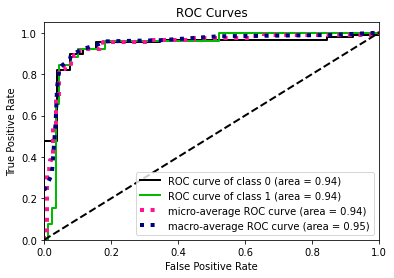

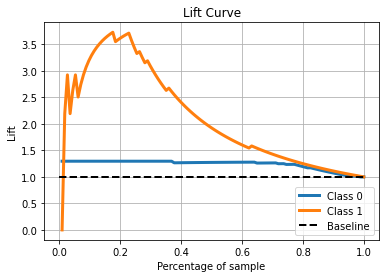

In [85]:
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print('Best params of SVM: ', svm_clf.best_params_)
print('Best cross validation score:', svm_clf.best_score_)
print("Prediction Accuracy: ",accuracy_score(y_test, svm_clf.predict(X_test)))

# Classification report
print(classification_report(y_test,svm_clf.predict(X_test)))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

#ROC
predicted_probas_svm = svm_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas_svm)

#Lift
skplt.metrics.plot_lift_curve(y_test, predicted_probas_svm)
plt.show()